In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
%matplotlib inline
import os
import re
print(os.listdir("E:/pythontraining/completeimarticus_tutorial/DL/Rnn/Sarcasm_Headlines_Dataset.json/"))



['model.h5', 'Sarcasm_Headlines_Dataset.json']


# Data Pre-Processing
- Getting rid of unwanted data
- Checking up if the data is normalized or not
- Filtering Headlines
- Defining max features
- Vectorize & Convert text for input
- Splitting data to train & test

In [12]:
df = pd.read_json('E:/pythontraining/completeimarticus_tutorial/DL/Rnn/Sarcasm_Headlines_Dataset.json/Sarcasm_Headlines_Dataset.json', lines=True)
df.head()


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


- ### Getting rid of unwanted data

In [13]:
df = df[['headline','is_sarcastic']]
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


- ### Checking for normalization

Text(0.5,1,'Sarcasm vs Non-sarcasm')

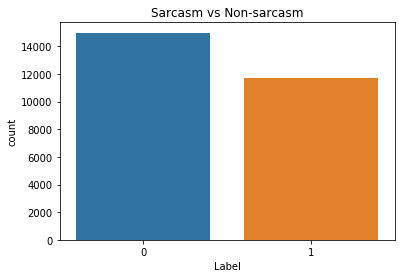

In [14]:
sns.countplot(df.is_sarcastic)
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')


- ### Filtering headlines 
- So that only valid headlines remain & 

In [15]:
df['headline'] = df['headline'].apply(lambda x: x.lower())
df['headline'] = df['headline'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


- ### Defining Max features 
- ### using Tokenizer to vectorize and convert text into Sequences 
 so that the Network can deal with it as input

In [16]:
for idx,row in df.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['headline'].values)
X = tokenizer.texts_to_sequences(df['headline'].values)
X = pad_sequences(X)

### Splitting data to train & test

In [17]:
Y = pd.get_dummies(df['is_sarcastic']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(17895, 29) (17895, 2)
(8814, 29) (8814, 2)


# Defining the LSTM RNN Model
With softmax activation

In [11]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

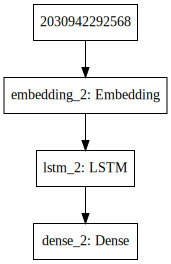

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

#### Training the model

In [14]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 3, batch_size=batch_size, verbose = 2)

Epoch 1/3
 - 54s - loss: 0.0895 - acc: 0.9653
Epoch 2/3
 - 61s - loss: 0.0750 - acc: 0.9714
Epoch 3/3
 - 60s - loss: 0.0596 - acc: 0.9780


Let's check the accuracy and score now

In [15]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 1.02
acc: 0.81


### A graph of accuracy & Loss vs Epoch

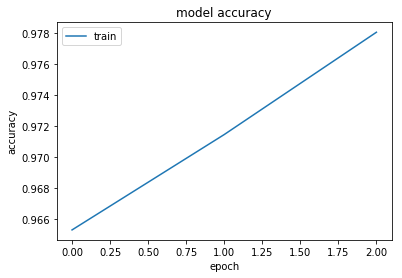

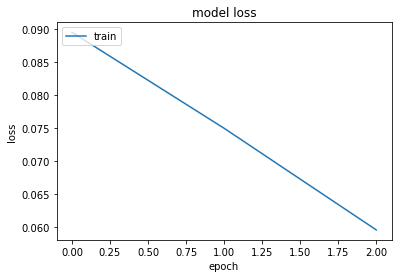

<Figure size 432x288 with 0 Axes>

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

#### Let's check it's score on sarcastic & non-sarcastic headlines respectively

In [17]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("Sarcasm_acc", pos_correct/pos_cnt*100, "%")
print("Non-Sarcasm_acc", neg_correct/neg_cnt*100, "%")

Sarcasm_acc 79.48717948717949 %
Non-Sarcasm_acc 83.39307048984467 %


In [18]:
headline = ['Chowkidar hi chor hai']
headline = tokenizer.texts_to_sequences(headline)
headline = pad_sequences(headline, maxlen=29, dtype='int32', value=0)

sentiment = model.predict(headline,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("Non-sarcastic")
elif (np.argmax(sentiment) == 1):
    print("Sarcasm")

Sarcasm


#### How to save and read back

In [19]:
#Save the model
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("E:/pythontraining/completeimarticus_tutorial/DL/Rnn/Sarcasm_Headlines_Dataset.json/model.h5")

In [7]:
def create_model():
    embed_dim = 128
    lstm_out = 196
    max_fatures = 2000


    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
    #model.add(SpatialDropout1D(0.4))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2,activation='softmax'))
    return model

In [8]:
weights_path="E:/pythontraining/completeimarticus_tutorial/DL/Rnn/Sarcasm_Headlines_Dataset.json/model.h5"

In [20]:
def load_trained_model(weights_path):
    model = create_model()
    model.load_weights(weights_path)
    return model

In [21]:
model2=load_trained_model(weights_path)

In [23]:
headline = ['Chowkidar hi chor hai']
headline = tokenizer.texts_to_sequences(headline)
headline = pad_sequences(headline, maxlen=29, dtype='int32', value=0)

sentiment = model2.predict(headline,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("Non-sarcastic")
elif (np.argmax(sentiment) == 1):
    print("Sarcasm")

Sarcasm
